In [5]:
# Importing modules and data
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, io
from torch import optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.utils as vutils
# for visualization
from matplotlib import pyplot as plt
import math
import numpy as np
import os
from PIL import Image
from torch.autograd import Variable
from torchvision.utils import save_image


In [2]:
# Loading the data
batch_size = 128
image_size = 128

num_gen_features = 64
num_dis_features = 64

gen_learning_rate =  0.0002
dis_learning_rate = 0.00002

# Hyperparameters
LATENT_SIZE = 120
NUM_EPOCHS = 10
BETA = 0.5


In [13]:
# Useful functions
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def prep_image(img):
    ret_img = 0.5 *(1 + torch.permute(img, (1, 2, 0)))
    return ret_img

In [14]:
# Reading in the images in both folders
data_matrix = []
tensor_maker = transforms.ToTensor()

list_images = os.listdir('./data_jpg/')
list_images = [x for x in list_images if x[0] != '.']

for i in list_images:
   png_img = Image.open('./data_jpg/' + i)
   img_arr = tensor_maker(png_img)
   data_matrix.append(img_arr)
   png_img.close()

# Doing some wacky stuff to get the images in the correct layout and values
# i.e. between 0 and 1 and then making it a numpy array again so that the whole thign
# can be a batched tensor with N, num_channels, H, W
for i, j in enumerate(data_matrix):
   data_matrix[i] = j.numpy()
data_matrix = np.array(data_matrix)
data_matrix = torch.Tensor(data_matrix)
# Normalizing between -1  and 1
transform = nn.Sequential(transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
data_matrix_tensor = transform(data_matrix)
print(data_matrix_tensor.shape)

torch.Size([1680, 3, 128, 128])


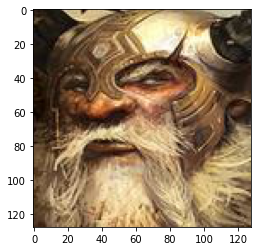

In [15]:
# Generating the dataloader
mydata = TensorDataset(data_matrix_tensor)
data_loader = DataLoader(mydata, batch_size=batch_size, shuffle=True)
plt.imshow(prep_image(data_matrix_tensor[500]))
plt.show()

In [16]:
class DCGenerator(nn.Module):
   # Initialization class
   def __init__(self):
      super(DCGenerator, self).__init__()
      self.generator = nn.Sequential(
         # input is of size LATENT SIZE
         # output of this is 4x4
         nn.ConvTranspose2d(LATENT_SIZE, num_gen_features * 8, kernel_size=4, stride=1, padding=0, bias=False),
         nn.BatchNorm2d(num_gen_features * 8),
         nn.ReLU(True),

         # output of this is 8x8
         nn.ConvTranspose2d(num_gen_features * 8,num_gen_features * 4, kernel_size=4, stride=2, padding=1, bias=False),
         nn.BatchNorm2d(num_gen_features * 4),
         nn.ReLU(True),

         # output of this is 16x16
         nn.ConvTranspose2d( num_gen_features * 4, num_gen_features * 3, kernel_size=4, stride=2, padding=1, bias=False),
         nn.BatchNorm2d(num_gen_features * 3),
         nn.ReLU(True),

         #output of this is 32x32
         nn.ConvTranspose2d(num_gen_features * 3, num_gen_features * 2, kernel_size=4, stride=2, padding=1, bias=False),
         nn.BatchNorm2d(num_gen_features*2),
         nn.ReLU(True),

         # Output of this is 
         nn.ConvTranspose2d(num_gen_features * 2, num_gen_features, kernel_size=3, stride=2, padding=1, bias=False),
         nn.BatchNorm2d(num_gen_features),
         nn.ReLU(True),

         #output of this is size 100x100
         nn.ConvTranspose2d(num_gen_features, 3, kernel_size=4, stride=2, padding=0, bias=False),
         nn.Tanh()
        )

   def forward(self, x):
      return self.generator(x)

In [17]:
# number discriminator features
class DCDiscriminator(nn.Module):
   def __init__(self):
      super(DCDiscriminator, self).__init__()
      self.discriminator = nn.Sequential(
         # Takes in 128x128
         nn.Conv2d(3, num_dis_features, kernel_size=3, stride=2, padding=1), 
         nn.LeakyReLU(0.2, inplace=True), 
         # Yields 64 x 64
         nn.Conv2d(num_dis_features, num_dis_features*2, kernel_size=4, stride=2, padding=1, bias=False),
         nn.BatchNorm2d(num_dis_features * 2), 
         nn.LeakyReLU(0.2, inplace=True),
         # Yields 32 x 32
         nn.Conv2d(num_dis_features*2, num_dis_features*4, kernel_size=4, stride=2, padding=1, bias=False),
         nn.BatchNorm2d(num_dis_features*4),
         nn.LeakyReLU(0.2, inplace=True),
         # Yields 16 x 16
         nn.Conv2d(num_dis_features*4, num_dis_features*8, kernel_size=4, stride=2, padding=1, bias=False),
         nn.BatchNorm2d(num_dis_features*8),
         nn.LeakyReLU(0.2, inplace=True),
         # Yields 8 x 8 
         nn.Conv2d(num_dis_features * 8, 1, kernel_size=8, stride=1, padding=0, bias=False),
         # Returns 1x1
         nn.Sigmoid(), 
         nn.Flatten()
      )
   
   def forward(self, x):
      return self.discriminator(x)

In [18]:
# Initializing the generator and discriminator
gen = DCGenerator()
dis = DCDiscriminator()
dis.apply(weights_init)
gen.apply(weights_init)

# Setting up the loss function
loss_func = nn.BCELoss()

# Optimizers
optim_gen = optim.Adam(gen.parameters(), lr=gen_learning_rate, betas =(BETA, 0.999))
optim_dis = optim.Adam(dis.parameters(), lr=dis_learning_rate, betas = (BETA, 0.999))

In [19]:
def train():
   G_loss = []
   D_loss = []
   
   for epoch in range(NUM_EPOCHS):
      print('EPOCH %d' % epoch)
      for batch, data in enumerate(data_loader):

         # Getting the data from the data_loader
         images = data[0]
         curr_batch_size = images.shape[0]

         #### Training the discriminator ####
         optim_dis.zero_grad()

         # Generating fake images
         noise = torch.randn(curr_batch_size, LATENT_SIZE, 1, 1)
         generated_data = gen(noise)

         # Fake and real labels
         true_labels = torch.ones(curr_batch_size, 1)
         false_labels = torch.zeros(curr_batch_size, 1)

         # Finding the loss over the fake labels
         discrim_fake = dis(generated_data.detach())
         fake_loss = loss_func(discrim_fake.reshape(curr_batch_size, 1), false_labels)

         # Finding the loss over the real labels
         discrim_real = dis(images.detach())
         true_loss = loss_func(discrim_real.reshape(curr_batch_size, 1), true_labels)

         # Backpropogating the loss
         dis_loss = ((fake_loss + true_loss) / 2)
         dis_loss.backward()
         optim_dis.step()
         D_loss.append(dis_loss.item())


         #### Training the generator ####
         optim_gen.zero_grad()

         # Generating fake images
         noise = torch.randn(curr_batch_size, LATENT_SIZE, 1, 1)
         generated_data = gen(noise)

         # Determining whether or not the discriminator is tricked
         trick_labels = torch.ones(curr_batch_size, 1)
         discrim_labels = dis(generated_data.detach())
         gen_loss = loss_func(discrim_labels.reshape(curr_batch_size, 1), trick_labels)

         # Backpropogating the loss
         gen_loss.backward()
         optim_gen.step()
         G_loss.append(gen_loss.item())
         print('Gen Loss = %f, Dis Loss = %f' % (gen_loss.item(), dis_loss.item()))


In [20]:
train()

EPOCH 0
Gen Loss = 1.004092, Dis Loss = 1.578714
Gen Loss = 2.197515, Dis Loss = 0.885592
Gen Loss = 3.056780, Dis Loss = 0.410583
Gen Loss = 3.705966, Dis Loss = 0.353027
Gen Loss = 3.854712, Dis Loss = 0.287771
Gen Loss = 4.161042, Dis Loss = 0.174252
Gen Loss = 3.820455, Dis Loss = 0.147858
Gen Loss = 4.251842, Dis Loss = 0.104436
Gen Loss = 4.390688, Dis Loss = 0.094752
Gen Loss = 4.580447, Dis Loss = 0.083672
Gen Loss = 4.932332, Dis Loss = 0.048884
Gen Loss = 5.260867, Dis Loss = 0.046331
Gen Loss = 5.083743, Dis Loss = 0.040874
Gen Loss = 5.406907, Dis Loss = 0.059486
EPOCH 1
Gen Loss = 5.165289, Dis Loss = 0.032986
Gen Loss = 4.994029, Dis Loss = 0.036722
Gen Loss = 5.508915, Dis Loss = 0.029029
Gen Loss = 5.405747, Dis Loss = 0.026783
Gen Loss = 5.750472, Dis Loss = 0.019494
Gen Loss = 6.132044, Dis Loss = 0.015769
Gen Loss = 5.604703, Dis Loss = 0.022592
Gen Loss = 5.864140, Dis Loss = 0.015624
Gen Loss = 6.061107, Dis Loss = 0.017786
Gen Loss = 6.317863, Dis Loss = 0.017333


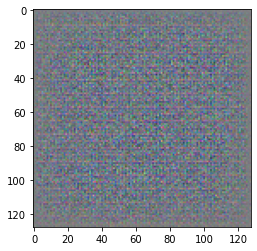

In [21]:
noise = torch.randn(1, LATENT_SIZE, 1, 1)
tensor_image = gen(noise).detach()[0]
plt.imshow(prep_image(tensor_image))

In [103]:

gen = Generator()
dis = Discriminator()

In [3]:
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [62]:
z = Variable(Tensor(np.random.normal(0, 1, (128, LATENT_SIZE))))


In [102]:
x = gen(z)

Input =  torch.Size([128, 120])
Out_linear =  torch.Size([128, 131072])
Reshaping Size =  torch.Size([128, 128, 32, 32])
torch.Size([128, 3, 128, 128])


torch.Size([128, 3, 116, 116])

In [77]:
dis(x)

torch.Size([128, 2048])


tensor([[0.5045],
        [0.5045],
        [0.5046],
        [0.5045],
        [0.5045],
        [0.5046],
        [0.5045],
        [0.5046],
        [0.5046],
        [0.5045],
        [0.5045],
        [0.5045],
        [0.5046],
        [0.5045],
        [0.5045],
        [0.5045],
        [0.5045],
        [0.5046],
        [0.5045],
        [0.5045],
        [0.5046],
        [0.5046],
        [0.5045],
        [0.5045],
        [0.5045],
        [0.5045],
        [0.5046],
        [0.5045],
        [0.5046],
        [0.5045],
        [0.5046],
        [0.5045],
        [0.5046],
        [0.5045],
        [0.5045],
        [0.5046],
        [0.5046],
        [0.5045],
        [0.5045],
        [0.5045],
        [0.5045],
        [0.5045],
        [0.5046],
        [0.5045],
        [0.5045],
        [0.5045],
        [0.5046],
        [0.5046],
        [0.5045],
        [0.5045],
        [0.5046],
        [0.5045],
        [0.5045],
        [0.5045],
        [0.5045],
        [0